In [1]:

import numpy as np
import networkx as nx
import itertools
import time
import matplotlib.pyplot as plt
import copy
### Parameters of figures

from pylab import rcParams

Here is the graph with 5 nodes we sampled


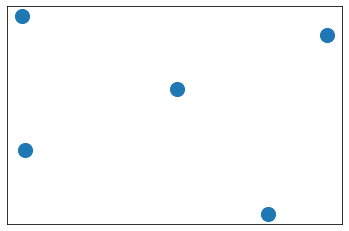

sample, (<networkx.classes.graph.Graph object at 0x122820ac0>, {0: (0.5891007334076902, 0.8150449588769378), 1: (0.9441139040298535, 0.9403693608068799), 2: (0.2242271106880035, 0.9827532168801224), 3: (0.8041152717612304, 0.5278762755574975), 4: (0.2313532044528721, 0.6750815061533408)})


In [2]:
# prep functions

### Function that computes the distance in the plane between points (x_1,x_2) and (y_1,y_2)

def compute_distance (x1,y1,x2,y2):
    return ((x1-x2)**2+(y1-y2)**2)**(.5)
    
### Function that generates a graph with n random vertices on the plane and weights given by the euclidean distances between those points 
### Input: n= number of nodes; should_print=0/1 (1 to plot a picture of the instance, 0 otherwise)
### Output: G = graph in NetworkX format, pos= coordinates of the points

def twod_instance(n,should_print):
    
    G=nx.Graph()
    lab=[]
    pos={}


    for i in range(0,n):
        x=np.random.random_sample()
        y=np.random.random_sample()
        G.add_node(i,x=x,y=y)
        pos[i]=(x,y)     # coordinates for drawing
        lab.append(i)       # label for drawing

# if should_print=1, we plot the graph

    if should_print == 1:
        print("Here is the graph with %d nodes we sampled" % n)
        
        nx.draw_networkx_nodes(G,pos,node_size=200)
        #nx.draw_networkx_labels(G,pos, node_size=100,label=lab)
            
        plt.show()
    
# assigning euclidean distances as weights

    for i in range(0,n):
        for j in range(i+1,n):
            G.add_edge(i,j, weight=compute_distance(G._node[i]['x'],G._node[i]['y'],G._node[j]['x'],G._node[j]['y']))
    return (G,pos)


print("sample,",twod_instance(5,1))



In [28]:
## Compare: greedy
def run_greedy_TSP(G,pos,should_print):   

    start_time = time.time()
    
    n=G.number_of_nodes()
    tour=[0]
    nr_cities=0
    length_tour=0


    while nr_cities<n-1:
        min_weight=999999
        candidate=-1
        for i in range(0,n):
            if (i not in tour):
                if G.edges[tour[nr_cities],i]['weight']< min_weight:
                    min_weight=G.edges[tour[nr_cities],i]['weight']
                    candidate=i
        tour.append(candidate)
        nr_cities=nr_cities+1
        length_tour=length_tour+min_weight

# don't forget we have to come back to the first node
    
    length_tour=length_tour+G.edges[0,tour[n-1]]['weight']
    
    final_time=time.time() - start_time

# if should_print=1, we plot the tour
    

    if should_print == 1:
        print(" **** Greedy Algorithm ***")
        print("")
        print("")
        G_final=nx.Graph()
        for i in range(n-1):
            G_final.add_edge(tour[i],tour[i+1])
        G_final.add_edge(tour[0],tour[n-1])

            
        #nx.draw_networkx_labels(G_final,pos,node_size=100,label=range(n))
        nx.draw_networkx(G_final,pos)
        plt.show()

# uncomment this if you want the tour and its cost to be output
            
#    print ("The greedy tour is %s and its total length is %f" % (tour,length_tour))
#    print("Running time of the greedy algorithm: %s seconds" % final_time) 
#    print("")
    print("Running time of Greedy: %s seconds" % final_time)
    
    return length_tour,tour # returns the total weight of the tour

    


 **** Greedy Algorithm ***




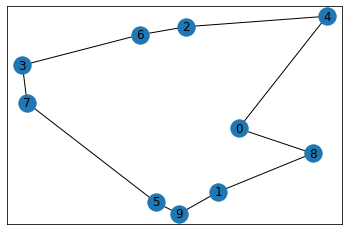

Running time of Greedy: 0.00015997886657714844 seconds


(2.436448578700324, [0, 8, 1, 9, 5, 7, 3, 6, 2, 4])

In [31]:
run_greedy_TSP(G10[0],G10[1],1)

In [4]:
# tabu search
#参考https://github.com/TheAlgorithms/Python/blob/master/searches/tabu_search.py
#first solution: obtained by greedy

def get_neighbor(G):
    
    neighbor_dict={}
    for n in list(G.nodes()):
        temp=[]
        
        n_neighbor=list(G.neighbors(n))
        for i in n_neighbor:
            w=G[n][i]['weight']
            temp.append([i,w])
        neighbor_dict[n]=temp
        
    return neighbor_dict

def find_neighborhood(solution, dict_of_neighbours):


    neighborhood_of_solution = []

    for n in solution[1:-1]:
        idx1 = solution.index(n)
        for kn in solution[1:-1]:
            idx2 = solution.index(kn)
            if n == kn:
                continue

            _tmp = copy.deepcopy(solution)
            _tmp[idx1] = kn
            _tmp[idx2] = n

            distance = 0

            for k in _tmp[:-1]:
                next_node = _tmp[_tmp.index(k) + 1]
                for i in dict_of_neighbours[k]:
                    if i[0] == next_node:
                        distance = distance + i[1]
            _tmp.append(distance)

            if _tmp not in neighborhood_of_solution:
                neighborhood_of_solution.append(_tmp)

    indexOfLastItemInTheList = len(neighborhood_of_solution[0]) - 1

    neighborhood_of_solution.sort(key=lambda x: x[indexOfLastItemInTheList])
    return neighborhood_of_solution


#find_neighborhood(run_greedy_TSP(tempG[0],tempG[1],0)[1],get_neighbor(tempG[0]))

In [39]:
def tabu_search(first_solution, dict_of_neighbours, iters, size):
    start_time = time.time()
    count=1
    solution=first_solution[1]
    tabu_list=[]
    best_cost=first_solution[0]
    ultimate_best_cost = solution

    while count <= iters:
        neighborhood = find_neighborhood(solution, dict_of_neighbours)
        index_of_best_solution = 0
        best_solution = neighborhood[index_of_best_solution]
        best_cost_index = len(best_solution) - 1

        found = False
        while not found:
            i = 0
            while i < len(best_solution):

                if best_solution[i] != solution[i]:
                    first_exchange_node = best_solution[i]
                    second_exchange_node = solution[i]
                    break
                i = i + 1

            if [first_exchange_node, second_exchange_node] not in tabu_list and [
                second_exchange_node,
                first_exchange_node,
            ] not in tabu_list:
                tabu_list.append([first_exchange_node, second_exchange_node])
                found = True
                solution = best_solution[:-1]
                cost = neighborhood[index_of_best_solution][best_cost_index]
                if cost < best_cost:
                    best_cost = cost
                    ultimate_best_solution = solution
            else:
                index_of_best_solution = index_of_best_solution + 1
                best_solution = neighborhood[index_of_best_solution]

        if len(tabu_list) >= size:
            tabu_list.pop(0)

        count = count + 1
    '''
    G_final=nx.Graph()
    for i in range(25-1):
        G_final.add_edge(ultimate_best_solution[i],ultimate_best_solution[i+1])
    G_final.add_edge(ultimate_best_solution[0],ultimate_best_solution[25-1])


    nx.draw_networkx(G_final,G25[1])
    plt.show()
    '''
    
    print("Running time of Tabu Search: %s seconds" % (time.time() - start_time))
    return best_cost, ultimate_best_solution



In [33]:
def SO_tabu_search(first_solution, dict_of_neighbours,  size):
    start_time = time.time()
    count=1
    iters=15
    solution=first_solution[1]
    tabu_list=[]
    best_cost=first_solution[0]
    ultimate_best_cost = solution
    
    prev_cost=best_cost
    
    while 1 <= iters:
        neighborhood = find_neighborhood(solution, dict_of_neighbours)
        index_of_best_solution = 0
        best_solution = neighborhood[index_of_best_solution]
        best_cost_index = len(best_solution) - 1

        found = False
        while not found:
            i = 0
            while i < len(best_solution):

                if best_solution[i] != solution[i]:
                    first_exchange_node = best_solution[i]
                    second_exchange_node = solution[i]
                    break
                i = i + 1

            if [first_exchange_node, second_exchange_node] not in tabu_list and [
                second_exchange_node,
                first_exchange_node,
            ] not in tabu_list:
                tabu_list.append([first_exchange_node, second_exchange_node])
                found = True
                solution = best_solution[:-1]
                cost = neighborhood[index_of_best_solution][best_cost_index]
                if cost < best_cost:
                    
                    best_cost = cost
                    ultimate_best_solution = solution
            else:
                index_of_best_solution = index_of_best_solution + 1
                best_solution = neighborhood[index_of_best_solution]

        if len(tabu_list) >= size:
            tabu_list.pop(0)
        if best_cost<prev_cost:
            iters = iters+5 
        else:
            iters = iters-5
        count=count+1
        
        prev_cost=best_cost
    print("Running time of SO Tabu Search: %s seconds" % (time.time() - start_time))
    print("SO Final iter count = ", count)
    return best_cost, ultimate_best_solution




In [18]:
print("test 10 nodes")
G10=twod_instance(10,0)
dict_neighbor=get_neighbor(G10[0])
first=run_greedy_TSP(G10[0],G10[1],0)
print("greedy solution: ",first[0])
print("tabu solution 5 iter:",tabu_search(first,dict_neighbor,5,10)[0])
print("SO tabu solution:",SO_tabu_search(first,dict_neighbor,10)[0])

test 10 nodes
Running time of Greedy: 0.00012111663818359375 seconds
greedy solution:  2.436448578700324
Running time of Tabu: 0.006246805191040039 seconds
tabu solution 5 iter: 2.104198523283667
Running time of SO Tabu Search: 0.00810694694519043 seconds
SO Final iter count =  6
SO tabu solution: 2.104198523283667


test 25 nodes
 **** Greedy Algorithm ***




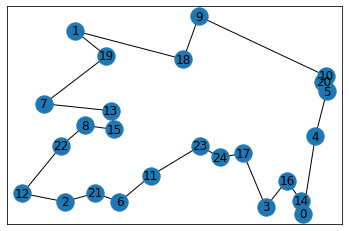

Running time of Greedy: 0.000644683837890625 seconds
greedy solution:  4.408062114714442


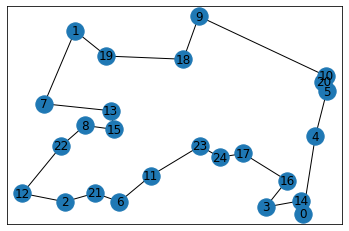

Running time of Tabu Search: 0.5615091323852539 seconds
tabu solution 13 iter: 3.9018573388296534
Running time of SO Tabu Search: 0.22116589546203613 seconds
SO Final iter count =  8
SO tabu solution: 3.9018573388296534


In [41]:
print("test 25 nodes")
G25=twod_instance(25,0)
dict_neighbor=get_neighbor(G25[0])
first=run_greedy_TSP(G25[0],G25[1],1)
print("greedy solution: ",first[0])
print("tabu solution 13 iter:",tabu_search(first,dict_neighbor,13,10)[0])
print("SO tabu solution:",SO_tabu_search(first,dict_neighbor,10)[0])

#### 改良： strategic oscillation

Strategic oscillation operates by orienting moves in relation to a critical
level, as identified by a stage of construction or a chosen interval of
functional values. Such a critical level or oscillation boundary often
represents a point where the method would normally stop. 

这里stop condition 是 reach max iterations。
可以先set max iterrations为小一点的数，
iter几轮之后（比如max iter数的几分之一？），check当前best solution，重复：
    如果和上一次iter没差多少，则剩余的iters数量减少
    如果和上一次iter进步很多，则剩余的iters数量增加
应该会渐渐趋于减少iters数，然后到达while loop的停止条件（15个nodes的图，50iter和100iter结果一样）
优化改良运算时间
    
    


In [20]:

print("test 50 nodes")
G50=twod_instance(50,0)
dict_neighbor=get_neighbor(G50[0])
first=run_greedy_TSP(G50[0],G50[1],0)
print("greedy solution: ",first[0])
print("tabu solution 25 iter:",tabu_search(first,dict_neighbor,25,10)[0])
print("SO tabu solution:",SO_tabu_search(first,dict_neighbor,10)[0])

test 50 nodes
Running time of Greedy: 0.0027527809143066406 seconds
greedy solution:  6.643467735123205
Running time of Tabu: 11.596192121505737 seconds
tabu solution 25 iter: 5.9831792558512795
Running time of SO Tabu Search: 5.04876708984375 seconds
SO Final iter count =  12
SO tabu solution: 5.9831792558512795


In [22]:
print("test 100 nodes")
G100=twod_instance(100,0)
dict_neighbor=get_neighbor(G100[0])
first=run_greedy_TSP(G100[0],G100[1],0)
print("greedy solution: ",first[0])
print("tabu solution 50 iter:",tabu_search(first,dict_neighbor,50,10)[0])
print("SO tabu solution:",SO_tabu_search(first,dict_neighbor,10)[0])

test 100 nodes
Running time of Greedy: 0.016812801361083984 seconds
greedy solution:  9.599329130545593
Running time of Tabu: 389.98048210144043 seconds
tabu solution 50 iter: 8.647417343411501
Running time of SO Tabu Search: 55.10982394218445 seconds
SO Final iter count =  8
SO tabu solution: 8.647417343411501
